In [133]:
%pip install pymer4

     |████████████████████████████████| 69 kB 1.9 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import pandas as pd
from bids import BIDSLayout
from joblib import Parallel, delayed
import nilearn
from nilearn import datasets, image, plotting, input_data
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, index_img
import numpy as np
from matplotlib import pyplot as plt
import rpy2
from rpy2.robjects.packages import importr
from pymer4 import Lmer
psych = importr('psych')

import scipy.stats as sp
import statistics as stat
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
bg_cnf = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/confound_iccs.csv')
bg_cnf = bg_cnf[bg_cnf.type == 'ICC2']

In [23]:
concat = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/concat_iccs2.csv')
concat = concat[concat.type == 'ICC2']

In [8]:
intrin_conn = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/intrinsic_connectivity_iccs.csv')
intrin_conn = intrin_conn[intrin_conn.type == 'ICC2']

In [9]:
bg_conn = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/background_connectivity_iccs.csv')
bg_conn = bg_conn[bg_conn.type == 'ICC2']

In [10]:
rs_conn = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/resting_state_iccs.csv')
rs_conn = rs_conn[rs_conn.type == 'ICC2']

In [11]:
rs_conn_cfds = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/resting_state_iccs_newcfds.csv')
rs_conn_cfds = rs_conn_cfds[rs_conn_cfds.type == 'ICC2']

In [12]:
rs_conn_complex = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/resting_state_iccs_complex.csv')
rs_conn_complex = rs_conn_complex[rs_conn_complex.type == 'ICC2']

In [13]:
intrin_conn_cfds = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/intrinsic_connectivity_iccs_newcfds.csv')
intrin_conn_cfds = intrin_conn_cfds[intrin_conn_cfds.type == 'ICC2']

In [14]:
intrin_conn_complex = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/intrinsic_connectivity_iccs_complex.csv')
intrin_conn_complex = intrin_conn_complex[intrin_conn_complex.type == 'ICC2']

In [4]:
rs_conn_physio = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/resting_state_iccs_physio.csv')
rs_conn_physio = rs_conn_physio[rs_conn_physio.type == 'ICC2']
rs_conn_physio.ICC.describe()

count    2652.000000
mean        0.152698
std         0.116697
min         0.000000
25%         0.063082
50%         0.137678
75%         0.216574
max         0.696629
Name: ICC, dtype: float64

In [5]:
bgc_conn_physio = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/bgc_iccs_physio.csv')
bgc_conn_physio = bgc_conn_physio[bgc_conn_physio.type == 'ICC2']
bgc_conn_physio.ICC.describe()

count    2652.000000
mean        0.251341
std         0.140064
min         0.000000
25%         0.148804
50%         0.243071
75%         0.347648
max         0.790776
Name: ICC, dtype: float64

In [6]:
ifc_conn_physio = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/ifc_iccs_physio.csv')
ifc_conn_physio = ifc_conn_physio[ifc_conn_physio.type == 'ICC2']
ifc_conn_physio.ICC.describe()

count    2652.000000
mean        0.239422
std         0.139563
min         0.000000
25%         0.136023
50%         0.233038
75%         0.335682
max         0.785705
Name: ICC, dtype: float64

In [7]:
measure_ind = []
for i in bgc_conn_physio.measure:
    splitstr = i.split('_')
    splitstr.sort()
    measure_ind.append(''.join(splitstr))
bgc_conn_physio['measure_ind'] = measure_ind
bgc_conn_physio = bgc_conn_physio.loc[bgc_conn_physio[bgc_conn_physio.columns[-1]].duplicated(keep='first') == False]

measure_ind = []
for i in ifc_conn_physio.measure:
    splitstr = i.split('_')
    splitstr.sort()
    measure_ind.append(''.join(splitstr))
ifc_conn_physio['measure_ind'] = measure_ind
ifc_conn_physio = ifc_conn_physio.loc[ifc_conn_physio[ifc_conn_physio.columns[-1]].duplicated(keep='first') == False]

measure_ind = []
for i in rs_conn_physio.measure:
    splitstr = i.split('_')
    splitstr.sort()
    measure_ind.append(''.join(splitstr))
rs_conn_physio['measure_ind'] = measure_ind
rs_conn_physio = rs_conn_physio.loc[rs_conn_physio[rs_conn_physio.columns[-1]].duplicated(keep='first') == False]

In [8]:
len(rs_conn_physio.ICC[rs_conn_physio.ICC >= .5])

16

In [9]:
len(ifc_conn_physio.ICC[ifc_conn_physio.ICC >= .5])

49

In [10]:
len(bgc_conn_physio.ICC[bgc_conn_physio.ICC >= .5])

56

In [24]:
measure_ind = []
for i in concat.measure:
    splitstr = i.split('_')
    splitstr.sort()
    measure_ind.append(''.join(splitstr))
concat['measure_ind'] = measure_ind
concat = concat.loc[concat[concat.columns[-1]].duplicated(keep='first') == False]

In [16]:
measure_ind = []
for i in bg_conn.measure:
    splitstr = i.split('_')
    splitstr.sort()
    measure_ind.append(''.join(splitstr))
bg_conn['measure_ind'] = measure_ind
bg_conn = bg_conn.loc[bg_conn[bg_conn.columns[-1]].duplicated(keep='first') == False]

In [17]:
measure_ind = []
for i in rs_conn_complex.measure:
    splitstr = i.split('_')
    splitstr.sort()
    measure_ind.append(''.join(splitstr))
rs_conn_complex['measure_ind'] = measure_ind
rs_conn_complex = rs_conn_complex.loc[rs_conn_complex[rs_conn_complex.columns[-1]].duplicated(keep='first') == False]

In [18]:
measure_ind = []
for i in intrin_conn_complex.measure:
    splitstr = i.split('_')
    splitstr.sort()
    measure_ind.append(''.join(splitstr))
intrin_conn_complex['measure_ind'] = measure_ind
intrin_conn_complex = intrin_conn_complex.loc[intrin_conn_complex[intrin_conn_complex.columns[-1]].duplicated(keep='first') == False]

In [28]:
print(sp.ttest_ind(concat.ICC,intrin_conn_complex.ICC, nan_policy = 'omit'),sp.ttest_ind(concat.ICC,bg_conn.ICC, nan_policy = 'omit'),sp.ttest_ind(concat.ICC,rs_conn_complex.ICC, nan_policy = 'omit'))

Ttest_indResult(statistic=2.444226111038727, pvalue=0.01458470455506783) Ttest_indResult(statistic=2.904485345686481, pvalue=0.003710722897943054) Ttest_indResult(statistic=19.709074578342705, pvalue=1.6227029713715764e-80)


In [146]:
sp.ttest_ind(bg_conn.ICC,intrin_conn_complex.ICC, nan_policy = 'omit')

Ttest_indResult(statistic=-0.47935531288218153, pvalue=0.6317276392505862)

In [147]:
sp.ttest_ind(rs_conn_complex.ICC,intrin_conn_complex.ICC, nan_policy = 'omit')

Ttest_indResult(statistic=-17.949072881014793, pvalue=7.1394971338772565e-68)

In [148]:
sp.ttest_ind(bg_conn.ICC,rs_conn_complex.ICC, nan_policy = 'omit')

Ttest_indResult(statistic=17.44801718803916, pvalue=1.942940547842119e-64)

In [157]:
len(intrin_conn_complex.ICC[intrin_conn_complex.ICC >= .5])

33

In [3]:
bg_cnf.ICC.describe()

count    2080.000000
mean        0.213942
std         0.217115
min         0.000000
25%         0.026696
50%         0.129259
75%         0.384862
max         0.834852
Name: ICC, dtype: float64

In [27]:
len(concat.ICC[concat.ICC >= .5])

57

In [155]:
intrin_conn_complex.ICC.describe()

count    1256.000000
mean        0.235326
std         0.127624
min         0.000000
25%         0.143463
50%         0.226695
75%         0.322308
max         0.709449
Name: ICC, dtype: float64

In [153]:
rs_conn_complex.ICC.describe()

count    1256.000000
mean        0.148395
std         0.114776
min         0.000000
25%         0.061534
50%         0.135349
75%         0.209168
max         0.683262
Name: ICC, dtype: float64

In [154]:
bg_conn.ICC.describe()

count    1256.000000
mean        0.232885
std         0.127585
min         0.000000
25%         0.142344
50%         0.225231
75%         0.319810
max         0.697041
Name: ICC, dtype: float64

In [9]:
intrin_conn.ICC.describe()

count    2652.000000
mean        0.350285
std         0.117292
min         0.012348
25%         0.259572
50%         0.362516
75%         0.440005
max         0.786371
Name: ICC, dtype: float64

In [11]:
stat.median(intrin_conn.ICC)

0.425258794777126

In [20]:
intrin_conn_cfds.ICC.describe()

count    2652.000000
mean        0.401947
std         0.131368
min         0.028559
25%         0.296536
50%         0.408850
75%         0.508058
max         0.809705
Name: ICC, dtype: float64

In [21]:
stat.median(intrin_conn_cfds.ICC)

0.4226560225608325

In [7]:
rs_conn.ICC.describe()

count    2652.000000
mean        0.317736
std         0.106375
min         0.000000
25%         0.254525
50%         0.337225
75%         0.392786
max         0.698972
Name: ICC, dtype: float64

In [13]:
stat.median(rs_conn.ICC)

0.1765911543827745

In [16]:
rs_conn_cfds.ICC.describe()

count    2652.000000
mean        0.351616
std         0.093181
min         0.000000
25%         0.297481
50%         0.357094
75%         0.413342
max         0.658294
Name: ICC, dtype: float64

In [18]:
stat.median(rs_conn_cfds.ICC)

0.29344321306551535

In [3]:
fs_dat = pd.read_csv('/data/MBDU/midla/notebooks/campcc/dat_paths_12092019.csv')
baseline_ses2_inc = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/correlation_matrix_baseline_ses2_inc_subjects.csv')
baseline_1yr_inc = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/correlation_matrix_baseline_one_year_inc_subjects.csv')
baseline_ses2 = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/correlation_matrix_baseline_ses2.csv')
baseline_1yr = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/correlation_matrix_baseline_one_year.csv')

In [12]:
matrix_ts1 = []
for i in range(0,50):
    matrix_ts1.append([])
    for j in range(0,50):
        matrix_ts1[i].append([])
        subject_values = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/ts_1/conn_matrix_{}_{}'.format(i,j),index_col=0)
        matrix_ts1[i][j] = subject_values

matrix_ts0 = []
for i in range(0,50):
    matrix_ts0.append([])
    for j in range(0,50):
        matrix_ts0[i].append([])
        subject_values = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/ts_0/conn_matrix_{}_{}'.format(i,j),index_col=0)
        matrix_ts0[i][j] = subject_values

In [121]:
test_dat = pd.DataFrame()

In [4]:
dat = pd.DataFrame()
dat['subject'] = ['']
dat['session'] = ['']
for i in range(0,50):
    for j in range(0,50):
        dat['{}_{}'.format(i,j)] = [0.0]
for _,row in fs_dat.iterrows():
    corr = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/corr_files/corr_matrix_sub-{}_ses-{}.csv'.format(row.subject,row.session),index_col=0)
    newrow = []
    newrow.append('{}'.format(row.subject))
    newrow.append('{}'.format(row.session))
    for i in range(0,50):
            for j in range(0,50):
                newrow.append(corr.loc[i][j])
    dat.loc[_] = newrow
    print('Done {} out of 440'.format(_))

FileNotFoundError: [Errno 2] File b'/data/MBDU/midla/notebooks/campcc/test_retest/corr_files/corr_matrix_sub-20900_ses-1.csv' does not exist: b'/data/MBDU/midla/notebooks/campcc/test_retest/corr_files/corr_matrix_sub-20900_ses-1.csv'

In [152]:
dat.to_csv('/data/MBDU/midla/notebooks/campcc/test_retest/icc_matrix.csv')

In [27]:
dat = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/matrix_for_icc.csv',index_col=0)

In [30]:
included_subjects = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/included_subjects.csv',index_col = 0)
included_subjects.reset_index(inplace=True)
dat = dat[dat['subject'].isin(included_subjects['SDAN'])]

In [16]:
dat.subject = dat.subject.astype(str)
dat.session = dat.session.astype(str)

In [19]:
dat.reset_index(inplace=True)

In [33]:
measure_iccs=[]
dat = dat.loc[dat[dat.columns[0:2]].duplicated(keep='last') == False]
single_ses_subs = dat.loc[dat.session.astype(int) <= 4, :].groupby('subject').session.nunique().reset_index().query('session <= 2').subject
dat_ind = ~dat.subject.isin(single_ses_subs) & (dat.session.astype(int) <= 4)
measure_cols = dat.columns[2:]
for mc in measure_cols:
    psych_dat = dat.loc[dat_ind, ['subject', 'session', mc]].set_index(['subject', 'session']).unstack()
    mc_res = psych.ICC(psych_dat, missing=False,alpha=.05/(1352))
    mc_res = mc_res[0].loc[['Single_random_raters', 'Single_fixed_raters']]
    mc_res['measure'] = mc
    measure_iccs.append(mc_res)
    print('Done {} of 2500'.format(len(measure_iccs)))
measure_iccs = pd.concat(measure_iccs)    

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1 of 2500
Done 2 of 2500
Done 3 of 2500
Done 4 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 5 of 2500
Done 6 of 2500
Done 7 of 2500
Done 8 of 2500
Done 9 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 10 of 2500
Done 11 of 2500
Done 12 of 2500
Done 13 of 2500
Done 14 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 15 of 2500
Done 16 of 2500
Done 17 of 2500
Done 18 of 2500
Done 19 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 20 of 2500
Done 21 of 2500
Done 22 of 2500
Done 23 of 2500
Done 24 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 25 of 2500
Done 26 of 2500
Done 27 of 2500
Done 28 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 29 of 2500
Done 30 of 2500
Done 31 of 2500
Done 32 of 2500
Done 33 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 34 of 2500
Done 35 of 2500
Done 36 of 2500
Done 37 of 2500
Done 38 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 39 of 2500
Done 40 of 2500
Done 41 of 2500
Done 42 of 2500
Done 43 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 44 of 2500
Done 45 of 2500
Done 46 of 2500
Done 47 of 2500
Done 48 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 49 of 2500
Done 50 of 2500
Done 51 of 2500
Done 52 of 2500
Done 53 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 54 of 2500
Done 55 of 2500
Done 56 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 57 of 2500
Done 58 of 2500
Done 59 of 2500
Done 60 of 2500
Done 61 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 62 of 2500
Done 63 of 2500
Done 64 of 2500
Done 65 of 2500
Done 66 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 67 of 2500
Done 68 of 2500
Done 69 of 2500
Done 70 of 2500
Done 71 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 72 of 2500
Done 73 of 2500
Done 74 of 2500
Done 75 of 2500
Done 76 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 77 of 2500
Done 78 of 2500
Done 79 of 2500
Done 80 of 2500
Done 81 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 82 of 2500
Done 83 of 2500
Done 84 of 2500
Done 85 of 2500
Done 86 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 87 of 2500
Done 88 of 2500
Done 89 of 2500
Done 90 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 91 of 2500
Done 92 of 2500
Done 93 of 2500
Done 94 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 95 of 2500
Done 96 of 2500
Done 97 of 2500
Done 98 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 99 of 2500
Done 100 of 2500
Done 101 of 2500
Done 102 of 2500
Done 103 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 104 of 2500
Done 105 of 2500
Done 106 of 2500
Done 107 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 108 of 2500
Done 109 of 2500
Done 110 of 2500
Done 111 of 2500
Done 112 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 113 of 2500
Done 114 of 2500
Done 115 of 2500
Done 116 of 2500
Done 117 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 118 of 2500
Done 119 of 2500
Done 120 of 2500
Done 121 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 122 of 2500
Done 123 of 2500
Done 124 of 2500
Done 125 of 2500
Done 126 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 127 of 2500
Done 128 of 2500
Done 129 of 2500
Done 130 of 2500
Done 131 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 132 of 2500
Done 133 of 2500
Done 134 of 2500
Done 135 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 136 of 2500
Done 137 of 2500
Done 138 of 2500
Done 139 of 2500
Done 140 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 141 of 2500
Done 142 of 2500
Done 143 of 2500
Done 144 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 145 of 2500
Done 146 of 2500
Done 147 of 2500
Done 148 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 149 of 2500
Done 150 of 2500
Done 151 of 2500
Done 152 of 2500
Done 153 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 154 of 2500
Done 155 of 2500
Done 156 of 2500
Done 157 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 158 of 2500
Done 159 of 2500
Done 160 of 2500
Done 161 of 2500
Done 162 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 163 of 2500
Done 164 of 2500
Done 165 of 2500
Done 166 of 2500
Done 167 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 168 of 2500
Done 169 of 2500
Done 170 of 2500
Done 171 of 2500
Done 172 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 173 of 2500
Done 174 of 2500
Done 175 of 2500
Done 176 of 2500
Done 177 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 178 of 2500
Done 179 of 2500
Done 180 of 2500
Done 181 of 2500
Done 182 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 183 of 2500
Done 184 of 2500
Done 185 of 2500
Done 186 of 2500
Done 187 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 188 of 2500
Done 189 of 2500
Done 190 of 2500
Done 191 of 2500
Done 192 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 193 of 2500
Done 194 of 2500
Done 195 of 2500
Done 196 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 197 of 2500
Done 198 of 2500
Done 199 of 2500
Done 200 of 2500
Done 201 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 202 of 2500
Done 203 of 2500
Done 204 of 2500
Done 205 of 2500
Done 206 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 207 of 2500
Done 208 of 2500
Done 209 of 2500
Done 210 of 2500
Done 211 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 212 of 2500
Done 213 of 2500
Done 214 of 2500
Done 215 of 2500
Done 216 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 217 of 2500
Done 218 of 2500
Done 219 of 2500
Done 220 of 2500
Done 221 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 222 of 2500
Done 223 of 2500
Done 224 of 2500
Done 225 of 2500
Done 226 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 227 of 2500
Done 228 of 2500
Done 229 of 2500
Done 230 of 2500
Done 231 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 232 of 2500
Done 233 of 2500
Done 234 of 2500
Done 235 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 236 of 2500
Done 237 of 2500
Done 238 of 2500
Done 239 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 240 of 2500
Done 241 of 2500
Done 242 of 2500
Done 243 of 2500
Done 244 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 245 of 2500
Done 246 of 2500
Done 247 of 2500
Done 248 of 2500
Done 249 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 250 of 2500
Done 251 of 2500
Done 252 of 2500
Done 253 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 254 of 2500
Done 255 of 2500
Done 256 of 2500
Done 257 of 2500
Done 258 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 259 of 2500
Done 260 of 2500
Done 261 of 2500
Done 262 of 2500
Done 263 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 264 of 2500
Done 265 of 2500
Done 266 of 2500
Done 267 of 2500
Done 268 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 269 of 2500
Done 270 of 2500
Done 271 of 2500
Done 272 of 2500
Done 273 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 274 of 2500
Done 275 of 2500
Done 276 of 2500
Done 277 of 2500
Done 278 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 279 of 2500
Done 280 of 2500
Done 281 of 2500
Done 282 of 2500
Done 283 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 284 of 2500
Done 285 of 2500
Done 286 of 2500
Done 287 of 2500
Done 288 of 2500
Done 289 of 2500
Done 290 of 2500
Done 291 of 2500
Done 292 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 293 of 2500
Done 294 of 2500
Done 295 of 2500
Done 296 of 2500
Done 297 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 298 of 2500
Done 299 of 2500
Done 300 of 2500
Done 301 of 2500
Done 302 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 303 of 2500
Done 304 of 2500
Done 305 of 2500
Done 306 of 2500
Done 307 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 308 of 2500
Done 309 of 2500
Done 310 of 2500
Done 311 of 2500
Done 312 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 313 of 2500
Done 314 of 2500
Done 315 of 2500
Done 316 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 317 of 2500
Done 318 of 2500
Done 319 of 2500
Done 320 of 2500
Done 321 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 322 of 2500
Done 323 of 2500
Done 324 of 2500
Done 325 of 2500
Done 326 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 327 of 2500
Done 328 of 2500
Done 329 of 2500
Done 330 of 2500
Done 331 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 332 of 2500
Done 333 of 2500
Done 334 of 2500
Done 335 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 336 of 2500
Done 337 of 2500
Done 338 of 2500
Done 339 of 2500
Done 340 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 341 of 2500
Done 342 of 2500
Done 343 of 2500
Done 344 of 2500
Done 345 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 346 of 2500
Done 347 of 2500
Done 348 of 2500
Done 349 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 350 of 2500
Done 351 of 2500
Done 352 of 2500
Done 353 of 2500
Done 354 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 355 of 2500
Done 356 of 2500
Done 357 of 2500
Done 358 of 2500
Done 359 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 360 of 2500
Done 361 of 2500
Done 362 of 2500
Done 363 of 2500
Done 364 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 365 of 2500
Done 366 of 2500
Done 367 of 2500
Done 368 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 369 of 2500
Done 370 of 2500
Done 371 of 2500
Done 372 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 373 of 2500
Done 374 of 2500
Done 375 of 2500
Done 376 of 2500
Done 377 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 378 of 2500
Done 379 of 2500
Done 380 of 2500
Done 381 of 2500
Done 382 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 383 of 2500
Done 384 of 2500
Done 385 of 2500
Done 386 of 2500
Done 387 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 388 of 2500
Done 389 of 2500
Done 390 of 2500
Done 391 of 2500
Done 392 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 393 of 2500
Done 394 of 2500
Done 395 of 2500
Done 396 of 2500
Done 397 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 398 of 2500
Done 399 of 2500
Done 400 of 2500
Done 401 of 2500
Done 402 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 403 of 2500
Done 404 of 2500
Done 405 of 2500
Done 406 of 2500
Done 407 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 408 of 2500
Done 409 of 2500
Done 410 of 2500
Done 411 of 2500
Done 412 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 413 of 2500
Done 414 of 2500
Done 415 of 2500
Done 416 of 2500
Done 417 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 418 of 2500
Done 419 of 2500
Done 420 of 2500
Done 421 of 2500
Done 422 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 423 of 2500
Done 424 of 2500
Done 425 of 2500
Done 426 of 2500
Done 427 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 428 of 2500
Done 429 of 2500
Done 430 of 2500
Done 431 of 2500
Done 432 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 433 of 2500
Done 434 of 2500
Done 435 of 2500
Done 436 of 2500
Done 437 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 438 of 2500
Done 439 of 2500
Done 440 of 2500
Done 441 of 2500
Done 442 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 443 of 2500
Done 444 of 2500
Done 445 of 2500
Done 446 of 2500
Done 447 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 448 of 2500
Done 449 of 2500
Done 450 of 2500
Done 451 of 2500
Done 452 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 453 of 2500
Done 454 of 2500
Done 455 of 2500
Done 456 of 2500
Done 457 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 458 of 2500
Done 459 of 2500
Done 460 of 2500
Done 461 of 2500
Done 462 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 463 of 2500
Done 464 of 2500
Done 465 of 2500
Done 466 of 2500
Done 467 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 468 of 2500
Done 469 of 2500
Done 470 of 2500
Done 471 of 2500
Done 472 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 473 of 2500
Done 474 of 2500
Done 475 of 2500
Done 476 of 2500
Done 477 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 478 of 2500
Done 479 of 2500
Done 480 of 2500
Done 481 of 2500
Done 482 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 483 of 2500
Done 484 of 2500
Done 485 of 2500
Done 486 of 2500
Done 487 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 488 of 2500
Done 489 of 2500
Done 490 of 2500
Done 491 of 2500
Done 492 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 493 of 2500
Done 494 of 2500
Done 495 of 2500
Done 496 of 2500
Done 497 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 498 of 2500
Done 499 of 2500
Done 500 of 2500
Done 501 of 2500
Done 502 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 503 of 2500
Done 504 of 2500
Done 505 of 2500
Done 506 of 2500
Done 507 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 508 of 2500
Done 509 of 2500
Done 510 of 2500
Done 511 of 2500
Done 512 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 513 of 2500
Done 514 of 2500
Done 515 of 2500
Done 516 of 2500
Done 517 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 518 of 2500
Done 519 of 2500
Done 520 of 2500
Done 521 of 2500
Done 522 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 523 of 2500
Done 524 of 2500
Done 525 of 2500
Done 526 of 2500
Done 527 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 528 of 2500
Done 529 of 2500
Done 530 of 2500
Done 531 of 2500
Done 532 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 533 of 2500
Done 534 of 2500
Done 535 of 2500
Done 536 of 2500
Done 537 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 538 of 2500
Done 539 of 2500
Done 540 of 2500
Done 541 of 2500
Done 542 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 543 of 2500
Done 544 of 2500
Done 545 of 2500
Done 546 of 2500
Done 547 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 548 of 2500
Done 549 of 2500
Done 550 of 2500
Done 551 of 2500
Done 552 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 553 of 2500
Done 554 of 2500
Done 555 of 2500
Done 556 of 2500
Done 557 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 558 of 2500
Done 559 of 2500
Done 560 of 2500
Done 561 of 2500
Done 562 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 563 of 2500
Done 564 of 2500
Done 565 of 2500
Done 566 of 2500
Done 567 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 568 of 2500
Done 569 of 2500
Done 570 of 2500
Done 571 of 2500
Done 572 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 573 of 2500
Done 574 of 2500
Done 575 of 2500
Done 576 of 2500
Done 577 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 578 of 2500
Done 579 of 2500
Done 580 of 2500
Done 581 of 2500
Done 582 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 583 of 2500
Done 584 of 2500
Done 585 of 2500
Done 586 of 2500
Done 587 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 588 of 2500
Done 589 of 2500
Done 590 of 2500
Done 591 of 2500
Done 592 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 593 of 2500
Done 594 of 2500
Done 595 of 2500
Done 596 of 2500
Done 597 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 598 of 2500
Done 599 of 2500
Done 600 of 2500
Done 601 of 2500
Done 602 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 603 of 2500
Done 604 of 2500
Done 605 of 2500
Done 606 of 2500
Done 607 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 608 of 2500
Done 609 of 2500
Done 610 of 2500
Done 611 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 612 of 2500
Done 613 of 2500
Done 614 of 2500
Done 615 of 2500
Done 616 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 617 of 2500
Done 618 of 2500
Done 619 of 2500
Done 620 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 621 of 2500
Done 622 of 2500
Done 623 of 2500
Done 624 of 2500
Done 625 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 626 of 2500
Done 627 of 2500
Done 628 of 2500
Done 629 of 2500
Done 630 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 631 of 2500
Done 632 of 2500
Done 633 of 2500
Done 634 of 2500
Done 635 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 636 of 2500
Done 637 of 2500
Done 638 of 2500
Done 639 of 2500
Done 640 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 641 of 2500
Done 642 of 2500
Done 643 of 2500
Done 644 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 645 of 2500
Done 646 of 2500
Done 647 of 2500
Done 648 of 2500
Done 649 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 650 of 2500
Done 651 of 2500
Done 652 of 2500
Done 653 of 2500
Done 654 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 655 of 2500
Done 656 of 2500
Done 657 of 2500
Done 658 of 2500
Done 659 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 660 of 2500
Done 661 of 2500
Done 662 of 2500
Done 663 of 2500
Done 664 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 665 of 2500
Done 666 of 2500
Done 667 of 2500
Done 668 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 669 of 2500
Done 670 of 2500
Done 671 of 2500
Done 672 of 2500
Done 673 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 674 of 2500
Done 675 of 2500
Done 676 of 2500
Done 677 of 2500
Done 678 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 679 of 2500
Done 680 of 2500
Done 681 of 2500
Done 682 of 2500
Done 683 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 684 of 2500
Done 685 of 2500
Done 686 of 2500
Done 687 of 2500
Done 688 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 689 of 2500
Done 690 of 2500
Done 691 of 2500
Done 692 of 2500
Done 693 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 694 of 2500
Done 695 of 2500
Done 696 of 2500
Done 697 of 2500
Done 698 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 699 of 2500
Done 700 of 2500
Done 701 of 2500
Done 702 of 2500
Done 703 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 704 of 2500
Done 705 of 2500
Done 706 of 2500
Done 707 of 2500
Done 708 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 709 of 2500
Done 710 of 2500
Done 711 of 2500
Done 712 of 2500
Done 713 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 714 of 2500
Done 715 of 2500
Done 716 of 2500
Done 717 of 2500
Done 718 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 719 of 2500
Done 720 of 2500
Done 721 of 2500
Done 722 of 2500
Done 723 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 724 of 2500
Done 725 of 2500
Done 726 of 2500
Done 727 of 2500
Done 728 of 2500
Done 729 of 2500
Done 730 of 2500
Done 731 of 2500
Done 732 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 733 of 2500
Done 734 of 2500
Done 735 of 2500
Done 736 of 2500
Done 737 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 738 of 2500
Done 739 of 2500
Done 740 of 2500
Done 741 of 2500
Done 742 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 743 of 2500
Done 744 of 2500
Done 745 of 2500
Done 746 of 2500
Done 747 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 748 of 2500
Done 749 of 2500
Done 750 of 2500
Done 751 of 2500
Done 752 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 753 of 2500
Done 754 of 2500
Done 755 of 2500
Done 756 of 2500
Done 757 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 758 of 2500
Done 759 of 2500
Done 760 of 2500
Done 761 of 2500
Done 762 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 763 of 2500
Done 764 of 2500
Done 765 of 2500
Done 766 of 2500
Done 767 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 768 of 2500
Done 769 of 2500
Done 770 of 2500
Done 771 of 2500
Done 772 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 773 of 2500
Done 774 of 2500
Done 775 of 2500
Done 776 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 777 of 2500
Done 778 of 2500
Done 779 of 2500
Done 780 of 2500
Done 781 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 782 of 2500
Done 783 of 2500
Done 784 of 2500
Done 785 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 786 of 2500
Done 787 of 2500
Done 788 of 2500
Done 789 of 2500
Done 790 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 791 of 2500
Done 792 of 2500
Done 793 of 2500
Done 794 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 795 of 2500
Done 796 of 2500
Done 797 of 2500
Done 798 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 799 of 2500
Done 800 of 2500
Done 801 of 2500
Done 802 of 2500
Done 803 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 804 of 2500
Done 805 of 2500
Done 806 of 2500
Done 807 of 2500
Done 808 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 809 of 2500
Done 810 of 2500
Done 811 of 2500
Done 812 of 2500
Done 813 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 814 of 2500
Done 815 of 2500
Done 816 of 2500
Done 817 of 2500
Done 818 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 819 of 2500
Done 820 of 2500
Done 821 of 2500
Done 822 of 2500
Done 823 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 824 of 2500
Done 825 of 2500
Done 826 of 2500
Done 827 of 2500
Done 828 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 829 of 2500
Done 830 of 2500
Done 831 of 2500
Done 832 of 2500
Done 833 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 834 of 2500
Done 835 of 2500
Done 836 of 2500
Done 837 of 2500
Done 838 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 839 of 2500
Done 840 of 2500
Done 841 of 2500
Done 842 of 2500
Done 843 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 844 of 2500
Done 845 of 2500
Done 846 of 2500
Done 847 of 2500
Done 848 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 849 of 2500
Done 850 of 2500
Done 851 of 2500
Done 852 of 2500
Done 853 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 854 of 2500
Done 855 of 2500
Done 856 of 2500
Done 857 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 858 of 2500
Done 859 of 2500
Done 860 of 2500
Done 861 of 2500
Done 862 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 863 of 2500
Done 864 of 2500
Done 865 of 2500
Done 866 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 867 of 2500
Done 868 of 2500
Done 869 of 2500
Done 870 of 2500
Done 871 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 872 of 2500
Done 873 of 2500
Done 874 of 2500
Done 875 of 2500
Done 876 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 877 of 2500
Done 878 of 2500
Done 879 of 2500
Done 880 of 2500
Done 881 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 882 of 2500
Done 883 of 2500
Done 884 of 2500
Done 885 of 2500
Done 886 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 887 of 2500
Done 888 of 2500
Done 889 of 2500
Done 890 of 2500
Done 891 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 892 of 2500
Done 893 of 2500
Done 894 of 2500
Done 895 of 2500
Done 896 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 897 of 2500
Done 898 of 2500
Done 899 of 2500
Done 900 of 2500
Done 901 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 902 of 2500
Done 903 of 2500
Done 904 of 2500
Done 905 of 2500
Done 906 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 907 of 2500
Done 908 of 2500
Done 909 of 2500
Done 910 of 2500
Done 911 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 912 of 2500
Done 913 of 2500
Done 914 of 2500
Done 915 of 2500
Done 916 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 917 of 2500
Done 918 of 2500
Done 919 of 2500
Done 920 of 2500
Done 921 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 922 of 2500
Done 923 of 2500
Done 924 of 2500
Done 925 of 2500
Done 926 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 927 of 2500
Done 928 of 2500
Done 929 of 2500
Done 930 of 2500
Done 931 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 932 of 2500
Done 933 of 2500
Done 934 of 2500
Done 935 of 2500
Done 936 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 937 of 2500
Done 938 of 2500
Done 939 of 2500
Done 940 of 2500
Done 941 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 942 of 2500
Done 943 of 2500
Done 944 of 2500
Done 945 of 2500
Done 946 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 947 of 2500
Done 948 of 2500
Done 949 of 2500
Done 950 of 2500
Done 951 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 952 of 2500
Done 953 of 2500
Done 954 of 2500
Done 955 of 2500
Done 956 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 957 of 2500
Done 958 of 2500
Done 959 of 2500
Done 960 of 2500
Done 961 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 962 of 2500
Done 963 of 2500
Done 964 of 2500
Done 965 of 2500
Done 966 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 967 of 2500
Done 968 of 2500
Done 969 of 2500
Done 970 of 2500
Done 971 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 972 of 2500
Done 973 of 2500
Done 974 of 2500
Done 975 of 2500
Done 976 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 977 of 2500
Done 978 of 2500
Done 979 of 2500
Done 980 of 2500
Done 981 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 982 of 2500
Done 983 of 2500
Done 984 of 2500
Done 985 of 2500
Done 986 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 987 of 2500
Done 988 of 2500
Done 989 of 2500
Done 990 of 2500
Done 991 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 992 of 2500
Done 993 of 2500
Done 994 of 2500
Done 995 of 2500
Done 996 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 997 of 2500
Done 998 of 2500
Done 999 of 2500
Done 1000 of 2500
Done 1001 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1002 of 2500
Done 1003 of 2500
Done 1004 of 2500
Done 1005 of 2500
Done 1006 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1007 of 2500
Done 1008 of 2500
Done 1009 of 2500
Done 1010 of 2500
Done 1011 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1012 of 2500
Done 1013 of 2500
Done 1014 of 2500
Done 1015 of 2500
Done 1016 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1017 of 2500
Done 1018 of 2500
Done 1019 of 2500
Done 1020 of 2500
Done 1021 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1022 of 2500
Done 1023 of 2500
Done 1024 of 2500
Done 1025 of 2500
Done 1026 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1027 of 2500
Done 1028 of 2500
Done 1029 of 2500
Done 1030 of 2500
Done 1031 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1032 of 2500
Done 1033 of 2500
Done 1034 of 2500
Done 1035 of 2500
Done 1036 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1037 of 2500
Done 1038 of 2500
Done 1039 of 2500
Done 1040 of 2500
Done 1041 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1042 of 2500
Done 1043 of 2500
Done 1044 of 2500
Done 1045 of 2500
Done 1046 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1047 of 2500
Done 1048 of 2500
Done 1049 of 2500
Done 1050 of 2500
Done 1051 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1052 of 2500
Done 1053 of 2500
Done 1054 of 2500
Done 1055 of 2500
Done 1056 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1057 of 2500
Done 1058 of 2500
Done 1059 of 2500
Done 1060 of 2500
Done 1061 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1062 of 2500
Done 1063 of 2500
Done 1064 of 2500
Done 1065 of 2500
Done 1066 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1067 of 2500
Done 1068 of 2500
Done 1069 of 2500
Done 1070 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1071 of 2500
Done 1072 of 2500
Done 1073 of 2500
Done 1074 of 2500
Done 1075 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1076 of 2500
Done 1077 of 2500
Done 1078 of 2500
Done 1079 of 2500
Done 1080 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1081 of 2500
Done 1082 of 2500
Done 1083 of 2500
Done 1084 of 2500
Done 1085 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1086 of 2500
Done 1087 of 2500
Done 1088 of 2500
Done 1089 of 2500
Done 1090 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1091 of 2500
Done 1092 of 2500
Done 1093 of 2500
Done 1094 of 2500
Done 1095 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1096 of 2500
Done 1097 of 2500
Done 1098 of 2500
Done 1099 of 2500
Done 1100 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1101 of 2500
Done 1102 of 2500
Done 1103 of 2500
Done 1104 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1105 of 2500
Done 1106 of 2500
Done 1107 of 2500
Done 1108 of 2500
Done 1109 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1110 of 2500
Done 1111 of 2500
Done 1112 of 2500
Done 1113 of 2500
Done 1114 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1115 of 2500
Done 1116 of 2500
Done 1117 of 2500
Done 1118 of 2500
Done 1119 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1120 of 2500
Done 1121 of 2500
Done 1122 of 2500
Done 1123 of 2500
Done 1124 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1125 of 2500
Done 1126 of 2500
Done 1127 of 2500
Done 1128 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1129 of 2500
Done 1130 of 2500
Done 1131 of 2500
Done 1132 of 2500
Done 1133 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1134 of 2500
Done 1135 of 2500
Done 1136 of 2500
Done 1137 of 2500
Done 1138 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1139 of 2500
Done 1140 of 2500
Done 1141 of 2500
Done 1142 of 2500
Done 1143 of 2500
Done 1144 of 2500
Done 1145 of 2500
Done 1146 of 2500
Done 1147 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1148 of 2500
Done 1149 of 2500
Done 1150 of 2500
Done 1151 of 2500
Done 1152 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1153 of 2500
Done 1154 of 2500
Done 1155 of 2500
Done 1156 of 2500
Done 1157 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1158 of 2500
Done 1159 of 2500
Done 1160 of 2500
Done 1161 of 2500
Done 1162 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1163 of 2500
Done 1164 of 2500
Done 1165 of 2500
Done 1166 of 2500
Done 1167 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1168 of 2500
Done 1169 of 2500
Done 1170 of 2500
Done 1171 of 2500
Done 1172 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1173 of 2500
Done 1174 of 2500
Done 1175 of 2500
Done 1176 of 2500
Done 1177 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1178 of 2500
Done 1179 of 2500
Done 1180 of 2500
Done 1181 of 2500
Done 1182 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1183 of 2500
Done 1184 of 2500
Done 1185 of 2500
Done 1186 of 2500
Done 1187 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1188 of 2500
Done 1189 of 2500
Done 1190 of 2500
Done 1191 of 2500
Done 1192 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1193 of 2500
Done 1194 of 2500
Done 1195 of 2500
Done 1196 of 2500
Done 1197 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1198 of 2500
Done 1199 of 2500
Done 1200 of 2500
Done 1201 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1202 of 2500
Done 1203 of 2500
Done 1204 of 2500
Done 1205 of 2500
Done 1206 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1207 of 2500
Done 1208 of 2500
Done 1209 of 2500
Done 1210 of 2500
Done 1211 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1212 of 2500
Done 1213 of 2500
Done 1214 of 2500
Done 1215 of 2500
Done 1216 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1217 of 2500
Done 1218 of 2500
Done 1219 of 2500
Done 1220 of 2500
Done 1221 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1222 of 2500
Done 1223 of 2500
Done 1224 of 2500
Done 1225 of 2500
Done 1226 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1227 of 2500
Done 1228 of 2500
Done 1229 of 2500
Done 1230 of 2500
Done 1231 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1232 of 2500
Done 1233 of 2500
Done 1234 of 2500
Done 1235 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1236 of 2500
Done 1237 of 2500
Done 1238 of 2500
Done 1239 of 2500
Done 1240 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1241 of 2500
Done 1242 of 2500
Done 1243 of 2500
Done 1244 of 2500
Done 1245 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1246 of 2500
Done 1247 of 2500
Done 1248 of 2500
Done 1249 of 2500
Done 1250 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1251 of 2500
Done 1252 of 2500
Done 1253 of 2500
Done 1254 of 2500
Done 1255 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1256 of 2500
Done 1257 of 2500
Done 1258 of 2500
Done 1259 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1260 of 2500
Done 1261 of 2500
Done 1262 of 2500
Done 1263 of 2500
Done 1264 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1265 of 2500
Done 1266 of 2500
Done 1267 of 2500
Done 1268 of 2500
Done 1269 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1270 of 2500
Done 1271 of 2500
Done 1272 of 2500
Done 1273 of 2500
Done 1274 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1275 of 2500
Done 1276 of 2500
Done 1277 of 2500
Done 1278 of 2500
Done 1279 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1280 of 2500
Done 1281 of 2500
Done 1282 of 2500
Done 1283 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1284 of 2500
Done 1285 of 2500
Done 1286 of 2500
Done 1287 of 2500
Done 1288 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1289 of 2500
Done 1290 of 2500
Done 1291 of 2500
Done 1292 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1293 of 2500
Done 1294 of 2500
Done 1295 of 2500
Done 1296 of 2500
Done 1297 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1298 of 2500
Done 1299 of 2500
Done 1300 of 2500
Done 1301 of 2500
Done 1302 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1303 of 2500
Done 1304 of 2500
Done 1305 of 2500
Done 1306 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1307 of 2500
Done 1308 of 2500
Done 1309 of 2500
Done 1310 of 2500
Done 1311 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1312 of 2500
Done 1313 of 2500
Done 1314 of 2500
Done 1315 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1316 of 2500
Done 1317 of 2500
Done 1318 of 2500
Done 1319 of 2500
Done 1320 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1321 of 2500
Done 1322 of 2500
Done 1323 of 2500
Done 1324 of 2500
Done 1325 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1326 of 2500
Done 1327 of 2500
Done 1328 of 2500
Done 1329 of 2500
Done 1330 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1331 of 2500
Done 1332 of 2500
Done 1333 of 2500
Done 1334 of 2500
Done 1335 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1336 of 2500
Done 1337 of 2500
Done 1338 of 2500
Done 1339 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1340 of 2500
Done 1341 of 2500
Done 1342 of 2500
Done 1343 of 2500
Done 1344 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1345 of 2500
Done 1346 of 2500
Done 1347 of 2500
Done 1348 of 2500
Done 1349 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1350 of 2500
Done 1351 of 2500
Done 1352 of 2500
Done 1353 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1354 of 2500
Done 1355 of 2500
Done 1356 of 2500
Done 1357 of 2500
Done 1358 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1359 of 2500
Done 1360 of 2500
Done 1361 of 2500
Done 1362 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1363 of 2500
Done 1364 of 2500
Done 1365 of 2500
Done 1366 of 2500
Done 1367 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1368 of 2500
Done 1369 of 2500
Done 1370 of 2500
Done 1371 of 2500
Done 1372 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1373 of 2500
Done 1374 of 2500
Done 1375 of 2500
Done 1376 of 2500
Done 1377 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1378 of 2500
Done 1379 of 2500
Done 1380 of 2500
Done 1381 of 2500
Done 1382 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1383 of 2500
Done 1384 of 2500
Done 1385 of 2500
Done 1386 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1387 of 2500
Done 1388 of 2500
Done 1389 of 2500
Done 1390 of 2500
Done 1391 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1392 of 2500
Done 1393 of 2500
Done 1394 of 2500
Done 1395 of 2500
Done 1396 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1397 of 2500
Done 1398 of 2500
Done 1399 of 2500
Done 1400 of 2500
Done 1401 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1402 of 2500
Done 1403 of 2500
Done 1404 of 2500
Done 1405 of 2500
Done 1406 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1407 of 2500
Done 1408 of 2500
Done 1409 of 2500
Done 1410 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1411 of 2500
Done 1412 of 2500
Done 1413 of 2500
Done 1414 of 2500
Done 1415 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1416 of 2500
Done 1417 of 2500
Done 1418 of 2500
Done 1419 of 2500
Done 1420 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1421 of 2500
Done 1422 of 2500
Done 1423 of 2500
Done 1424 of 2500
Done 1425 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1426 of 2500
Done 1427 of 2500
Done 1428 of 2500
Done 1429 of 2500
Done 1430 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1431 of 2500
Done 1432 of 2500
Done 1433 of 2500
Done 1434 of 2500
Done 1435 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1436 of 2500
Done 1437 of 2500
Done 1438 of 2500
Done 1439 of 2500
Done 1440 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1441 of 2500
Done 1442 of 2500
Done 1443 of 2500
Done 1444 of 2500
Done 1445 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1446 of 2500
Done 1447 of 2500
Done 1448 of 2500
Done 1449 of 2500
Done 1450 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1451 of 2500
Done 1452 of 2500
Done 1453 of 2500
Done 1454 of 2500
Done 1455 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1456 of 2500
Done 1457 of 2500
Done 1458 of 2500
Done 1459 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1460 of 2500
Done 1461 of 2500
Done 1462 of 2500
Done 1463 of 2500
Done 1464 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1465 of 2500
Done 1466 of 2500
Done 1467 of 2500
Done 1468 of 2500
Done 1469 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1470 of 2500
Done 1471 of 2500
Done 1472 of 2500
Done 1473 of 2500
Done 1474 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1475 of 2500
Done 1476 of 2500
Done 1477 of 2500
Done 1478 of 2500
Done 1479 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1480 of 2500
Done 1481 of 2500
Done 1482 of 2500
Done 1483 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1484 of 2500
Done 1485 of 2500
Done 1486 of 2500
Done 1487 of 2500
Done 1488 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1489 of 2500
Done 1490 of 2500
Done 1491 of 2500
Done 1492 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1493 of 2500
Done 1494 of 2500
Done 1495 of 2500
Done 1496 of 2500
Done 1497 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1498 of 2500
Done 1499 of 2500
Done 1500 of 2500
Done 1501 of 2500
Done 1502 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1503 of 2500
Done 1504 of 2500
Done 1505 of 2500
Done 1506 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1507 of 2500
Done 1508 of 2500
Done 1509 of 2500
Done 1510 of 2500
Done 1511 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1512 of 2500
Done 1513 of 2500
Done 1514 of 2500
Done 1515 of 2500
Done 1516 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1517 of 2500
Done 1518 of 2500
Done 1519 of 2500
Done 1520 of 2500
Done 1521 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1522 of 2500
Done 1523 of 2500
Done 1524 of 2500
Done 1525 of 2500
Done 1526 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1527 of 2500
Done 1528 of 2500
Done 1529 of 2500
Done 1530 of 2500
Done 1531 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1532 of 2500
Done 1533 of 2500
Done 1534 of 2500
Done 1535 of 2500
Done 1536 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1537 of 2500
Done 1538 of 2500
Done 1539 of 2500
Done 1540 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1541 of 2500
Done 1542 of 2500
Done 1543 of 2500
Done 1544 of 2500
Done 1545 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1546 of 2500
Done 1547 of 2500
Done 1548 of 2500
Done 1549 of 2500
Done 1550 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1551 of 2500
Done 1552 of 2500
Done 1553 of 2500
Done 1554 of 2500
Done 1555 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1556 of 2500
Done 1557 of 2500
Done 1558 of 2500
Done 1559 of 2500
Done 1560 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1561 of 2500
Done 1562 of 2500
Done 1563 of 2500
Done 1564 of 2500
Done 1565 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1566 of 2500
Done 1567 of 2500
Done 1568 of 2500
Done 1569 of 2500
Done 1570 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1571 of 2500
Done 1572 of 2500
Done 1573 of 2500
Done 1574 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1575 of 2500
Done 1576 of 2500
Done 1577 of 2500
Done 1578 of 2500
Done 1579 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1580 of 2500
Done 1581 of 2500
Done 1582 of 2500
Done 1583 of 2500
Done 1584 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1585 of 2500
Done 1586 of 2500
Done 1587 of 2500
Done 1588 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1589 of 2500
Done 1590 of 2500
Done 1591 of 2500
Done 1592 of 2500
Done 1593 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1594 of 2500
Done 1595 of 2500
Done 1596 of 2500
Done 1597 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1598 of 2500
Done 1599 of 2500
Done 1600 of 2500
Done 1601 of 2500
Done 1602 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1603 of 2500
Done 1604 of 2500
Done 1605 of 2500
Done 1606 of 2500
Done 1607 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1608 of 2500
Done 1609 of 2500
Done 1610 of 2500
Done 1611 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1612 of 2500
Done 1613 of 2500
Done 1614 of 2500
Done 1615 of 2500
Done 1616 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1617 of 2500
Done 1618 of 2500
Done 1619 of 2500
Done 1620 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1621 of 2500
Done 1622 of 2500
Done 1623 of 2500
Done 1624 of 2500
Done 1625 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1626 of 2500
Done 1627 of 2500
Done 1628 of 2500
Done 1629 of 2500
Done 1630 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1631 of 2500
Done 1632 of 2500
Done 1633 of 2500
Done 1634 of 2500
Done 1635 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1636 of 2500
Done 1637 of 2500
Done 1638 of 2500
Done 1639 of 2500
Done 1640 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1641 of 2500
Done 1642 of 2500
Done 1643 of 2500
Done 1644 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1645 of 2500
Done 1646 of 2500
Done 1647 of 2500
Done 1648 of 2500
Done 1649 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1650 of 2500
Done 1651 of 2500
Done 1652 of 2500
Done 1653 of 2500
Done 1654 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1655 of 2500
Done 1656 of 2500
Done 1657 of 2500
Done 1658 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1659 of 2500
Done 1660 of 2500
Done 1661 of 2500
Done 1662 of 2500
Done 1663 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1664 of 2500
Done 1665 of 2500
Done 1666 of 2500
Done 1667 of 2500
Done 1668 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1669 of 2500
Done 1670 of 2500
Done 1671 of 2500
Done 1672 of 2500
Done 1673 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1674 of 2500
Done 1675 of 2500
Done 1676 of 2500
Done 1677 of 2500
Done 1678 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1679 of 2500
Done 1680 of 2500
Done 1681 of 2500
Done 1682 of 2500
Done 1683 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1684 of 2500
Done 1685 of 2500
Done 1686 of 2500
Done 1687 of 2500
Done 1688 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1689 of 2500
Done 1690 of 2500
Done 1691 of 2500
Done 1692 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1693 of 2500
Done 1694 of 2500
Done 1695 of 2500
Done 1696 of 2500
Done 1697 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1698 of 2500
Done 1699 of 2500
Done 1700 of 2500
Done 1701 of 2500
Done 1702 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1703 of 2500
Done 1704 of 2500
Done 1705 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1706 of 2500
Done 1707 of 2500
Done 1708 of 2500
Done 1709 of 2500
Done 1710 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1711 of 2500
Done 1712 of 2500
Done 1713 of 2500
Done 1714 of 2500
Done 1715 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1716 of 2500
Done 1717 of 2500
Done 1718 of 2500
Done 1719 of 2500
Done 1720 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1721 of 2500
Done 1722 of 2500
Done 1723 of 2500
Done 1724 of 2500
Done 1725 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1726 of 2500
Done 1727 of 2500
Done 1728 of 2500
Done 1729 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1730 of 2500
Done 1731 of 2500
Done 1732 of 2500
Done 1733 of 2500
Done 1734 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1735 of 2500
Done 1736 of 2500
Done 1737 of 2500
Done 1738 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1739 of 2500
Done 1740 of 2500
Done 1741 of 2500
Done 1742 of 2500
Done 1743 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1744 of 2500
Done 1745 of 2500
Done 1746 of 2500
Done 1747 of 2500
Done 1748 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1749 of 2500
Done 1750 of 2500
Done 1751 of 2500
Done 1752 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1753 of 2500
Done 1754 of 2500
Done 1755 of 2500
Done 1756 of 2500
Done 1757 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1758 of 2500
Done 1759 of 2500
Done 1760 of 2500
Done 1761 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1762 of 2500
Done 1763 of 2500
Done 1764 of 2500
Done 1765 of 2500
Done 1766 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1767 of 2500
Done 1768 of 2500
Done 1769 of 2500
Done 1770 of 2500
Done 1771 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1772 of 2500
Done 1773 of 2500
Done 1774 of 2500
Done 1775 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1776 of 2500
Done 1777 of 2500
Done 1778 of 2500
Done 1779 of 2500
Done 1780 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1781 of 2500
Done 1782 of 2500
Done 1783 of 2500
Done 1784 of 2500
Done 1785 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1786 of 2500
Done 1787 of 2500
Done 1788 of 2500
Done 1789 of 2500
Done 1790 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1791 of 2500
Done 1792 of 2500
Done 1793 of 2500
Done 1794 of 2500
Done 1795 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1796 of 2500
Done 1797 of 2500
Done 1798 of 2500
Done 1799 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1800 of 2500
Done 1801 of 2500
Done 1802 of 2500
Done 1803 of 2500
Done 1804 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1805 of 2500
Done 1806 of 2500
Done 1807 of 2500
Done 1808 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1809 of 2500
Done 1810 of 2500
Done 1811 of 2500
Done 1812 of 2500
Done 1813 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1814 of 2500
Done 1815 of 2500
Done 1816 of 2500
Done 1817 of 2500
Done 1818 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1819 of 2500
Done 1820 of 2500
Done 1821 of 2500
Done 1822 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1823 of 2500
Done 1824 of 2500
Done 1825 of 2500
Done 1826 of 2500
Done 1827 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1828 of 2500
Done 1829 of 2500
Done 1830 of 2500
Done 1831 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1832 of 2500
Done 1833 of 2500
Done 1834 of 2500
Done 1835 of 2500
Done 1836 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1837 of 2500
Done 1838 of 2500
Done 1839 of 2500
Done 1840 of 2500
Done 1841 of 2500
Done 1842 of 2500
Done 1843 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1844 of 2500
Done 1845 of 2500
Done 1846 of 2500
Done 1847 of 2500
Done 1848 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1849 of 2500
Done 1850 of 2500
Done 1851 of 2500
Done 1852 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1853 of 2500
Done 1854 of 2500
Done 1855 of 2500
Done 1856 of 2500
Done 1857 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1858 of 2500
Done 1859 of 2500
Done 1860 of 2500
Done 1861 of 2500
Done 1862 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1863 of 2500
Done 1864 of 2500
Done 1865 of 2500
Done 1866 of 2500
Done 1867 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1868 of 2500
Done 1869 of 2500
Done 1870 of 2500
Done 1871 of 2500
Done 1872 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1873 of 2500
Done 1874 of 2500
Done 1875 of 2500
Done 1876 of 2500
Done 1877 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1878 of 2500
Done 1879 of 2500
Done 1880 of 2500
Done 1881 of 2500
Done 1882 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1883 of 2500
Done 1884 of 2500
Done 1885 of 2500
Done 1886 of 2500
Done 1887 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1888 of 2500
Done 1889 of 2500
Done 1890 of 2500
Done 1891 of 2500
Done 1892 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1893 of 2500
Done 1894 of 2500
Done 1895 of 2500
Done 1896 of 2500
Done 1897 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1898 of 2500
Done 1899 of 2500
Done 1900 of 2500
Done 1901 of 2500
Done 1902 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1903 of 2500
Done 1904 of 2500
Done 1905 of 2500
Done 1906 of 2500
Done 1907 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1908 of 2500
Done 1909 of 2500
Done 1910 of 2500
Done 1911 of 2500
Done 1912 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1913 of 2500
Done 1914 of 2500
Done 1915 of 2500
Done 1916 of 2500
Done 1917 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1918 of 2500
Done 1919 of 2500
Done 1920 of 2500
Done 1921 of 2500
Done 1922 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1923 of 2500
Done 1924 of 2500
Done 1925 of 2500
Done 1926 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1927 of 2500
Done 1928 of 2500
Done 1929 of 2500
Done 1930 of 2500
Done 1931 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1932 of 2500
Done 1933 of 2500
Done 1934 of 2500
Done 1935 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1936 of 2500
Done 1937 of 2500
Done 1938 of 2500
Done 1939 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1940 of 2500
Done 1941 of 2500
Done 1942 of 2500
Done 1943 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1944 of 2500
Done 1945 of 2500
Done 1946 of 2500
Done 1947 of 2500
Done 1948 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1949 of 2500
Done 1950 of 2500
Done 1951 of 2500
Done 1952 of 2500
Done 1953 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1954 of 2500
Done 1955 of 2500
Done 1956 of 2500
Done 1957 of 2500
Done 1958 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1959 of 2500
Done 1960 of 2500
Done 1961 of 2500
Done 1962 of 2500
Done 1963 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 1964 of 2500
Done 1965 of 2500
Done 1966 of 2500
Done 1967 of 2500
Done 1968 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1969 of 2500
Done 1970 of 2500
Done 1971 of 2500
Done 1972 of 2500
Done 1973 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1974 of 2500
Done 1975 of 2500
Done 1976 of 2500
Done 1977 of 2500
Done 1978 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1979 of 2500
Done 1980 of 2500
Done 1981 of 2500
Done 1982 of 2500
Done 1983 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1984 of 2500
Done 1985 of 2500
Done 1986 of 2500
Done 1987 of 2500
Done 1988 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1989 of 2500
Done 1990 of 2500
Done 1991 of 2500
Done 1992 of 2500
Done 1993 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1994 of 2500
Done 1995 of 2500
Done 1996 of 2500
Done 1997 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 1998 of 2500
Done 1999 of 2500
Done 2000 of 2500
Done 2001 of 2500
Done 2002 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2003 of 2500
Done 2004 of 2500
Done 2005 of 2500
Done 2006 of 2500
Done 2007 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2008 of 2500
Done 2009 of 2500
Done 2010 of 2500
Done 2011 of 2500
Done 2012 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2013 of 2500
Done 2014 of 2500
Done 2015 of 2500
Done 2016 of 2500
Done 2017 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2018 of 2500
Done 2019 of 2500
Done 2020 of 2500
Done 2021 of 2500
Done 2022 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2023 of 2500
Done 2024 of 2500
Done 2025 of 2500
Done 2026 of 2500
Done 2027 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2028 of 2500
Done 2029 of 2500
Done 2030 of 2500
Done 2031 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2032 of 2500
Done 2033 of 2500
Done 2034 of 2500
Done 2035 of 2500
Done 2036 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2037 of 2500
Done 2038 of 2500
Done 2039 of 2500
Done 2040 of 2500
Done 2041 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2042 of 2500
Done 2043 of 2500
Done 2044 of 2500
Done 2045 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2046 of 2500
Done 2047 of 2500
Done 2048 of 2500
Done 2049 of 2500
Done 2050 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2051 of 2500
Done 2052 of 2500
Done 2053 of 2500
Done 2054 of 2500
Done 2055 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2056 of 2500
Done 2057 of 2500
Done 2058 of 2500
Done 2059 of 2500
Done 2060 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2061 of 2500
Done 2062 of 2500
Done 2063 of 2500
Done 2064 of 2500
Done 2065 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2066 of 2500
Done 2067 of 2500
Done 2068 of 2500
Done 2069 of 2500
Done 2070 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2071 of 2500
Done 2072 of 2500
Done 2073 of 2500
Done 2074 of 2500
Done 2075 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2076 of 2500
Done 2077 of 2500
Done 2078 of 2500
Done 2079 of 2500
Done 2080 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2081 of 2500
Done 2082 of 2500
Done 2083 of 2500
Done 2084 of 2500
Done 2085 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2086 of 2500
Done 2087 of 2500
Done 2088 of 2500
Done 2089 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2090 of 2500
Done 2091 of 2500
Done 2092 of 2500
Done 2093 of 2500
Done 2094 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2095 of 2500
Done 2096 of 2500
Done 2097 of 2500
Done 2098 of 2500
Done 2099 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2100 of 2500
Done 2101 of 2500
Done 2102 of 2500
Done 2103 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2104 of 2500
Done 2105 of 2500
Done 2106 of 2500
Done 2107 of 2500
Done 2108 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2109 of 2500
Done 2110 of 2500
Done 2111 of 2500
Done 2112 of 2500
Done 2113 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2114 of 2500
Done 2115 of 2500
Done 2116 of 2500
Done 2117 of 2500
Done 2118 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2119 of 2500
Done 2120 of 2500
Done 2121 of 2500
Done 2122 of 2500
Done 2123 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2124 of 2500
Done 2125 of 2500
Done 2126 of 2500
Done 2127 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2128 of 2500
Done 2129 of 2500
Done 2130 of 2500
Done 2131 of 2500
Done 2132 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2133 of 2500
Done 2134 of 2500
Done 2135 of 2500
Done 2136 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2137 of 2500
Done 2138 of 2500
Done 2139 of 2500
Done 2140 of 2500
Done 2141 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2142 of 2500
Done 2143 of 2500
Done 2144 of 2500
Done 2145 of 2500
Done 2146 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2147 of 2500
Done 2148 of 2500
Done 2149 of 2500
Done 2150 of 2500
Done 2151 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2152 of 2500
Done 2153 of 2500
Done 2154 of 2500
Done 2155 of 2500
Done 2156 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2157 of 2500
Done 2158 of 2500
Done 2159 of 2500
Done 2160 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2161 of 2500
Done 2162 of 2500
Done 2163 of 2500
Done 2164 of 2500
Done 2165 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2166 of 2500
Done 2167 of 2500
Done 2168 of 2500
Done 2169 of 2500
Done 2170 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2171 of 2500
Done 2172 of 2500
Done 2173 of 2500
Done 2174 of 2500
Done 2175 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2176 of 2500
Done 2177 of 2500
Done 2178 of 2500
Done 2179 of 2500
Done 2180 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2181 of 2500
Done 2182 of 2500
Done 2183 of 2500
Done 2184 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2185 of 2500
Done 2186 of 2500
Done 2187 of 2500
Done 2188 of 2500
Done 2189 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2190 of 2500
Done 2191 of 2500
Done 2192 of 2500
Done 2193 of 2500
Done 2194 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2195 of 2500
Done 2196 of 2500
Done 2197 of 2500
Done 2198 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2199 of 2500
Done 2200 of 2500
Done 2201 of 2500
Done 2202 of 2500
Done 2203 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2204 of 2500
Done 2205 of 2500
Done 2206 of 2500
Done 2207 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2208 of 2500
Done 2209 of 2500
Done 2210 of 2500
Done 2211 of 2500
Done 2212 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2213 of 2500
Done 2214 of 2500
Done 2215 of 2500
Done 2216 of 2500
Done 2217 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2218 of 2500
Done 2219 of 2500
Done 2220 of 2500
Done 2221 of 2500
Done 2222 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2223 of 2500
Done 2224 of 2500
Done 2225 of 2500
Done 2226 of 2500
Done 2227 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2228 of 2500
Done 2229 of 2500
Done 2230 of 2500
Done 2231 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2232 of 2500
Done 2233 of 2500
Done 2234 of 2500
Done 2235 of 2500
Done 2236 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2237 of 2500
Done 2238 of 2500
Done 2239 of 2500
Done 2240 of 2500
Done 2241 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2242 of 2500
Done 2243 of 2500
Done 2244 of 2500
Done 2245 of 2500
Done 2246 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2247 of 2500
Done 2248 of 2500
Done 2249 of 2500
Done 2250 of 2500
Done 2251 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2252 of 2500
Done 2253 of 2500
Done 2254 of 2500
Done 2255 of 2500
Done 2256 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2257 of 2500
Done 2258 of 2500
Done 2259 of 2500
Done 2260 of 2500
Done 2261 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2262 of 2500
Done 2263 of 2500
Done 2264 of 2500
Done 2265 of 2500
Done 2266 of 2500
Done 2267 of 2500
Done 2268 of 2500
Done 2269 of 2500
Done 2270 of 2500
Done 2271 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2272 of 2500
Done 2273 of 2500
Done 2274 of 2500
Done 2275 of 2500
Done 2276 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2277 of 2500
Done 2278 of 2500
Done 2279 of 2500
Done 2280 of 2500
Done 2281 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2282 of 2500
Done 2283 of 2500
Done 2284 of 2500
Done 2285 of 2500
Done 2286 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2287 of 2500
Done 2288 of 2500
Done 2289 of 2500
Done 2290 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2291 of 2500
Done 2292 of 2500
Done 2293 of 2500
Done 2294 of 2500
Done 2295 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2296 of 2500
Done 2297 of 2500
Done 2298 of 2500
Done 2299 of 2500
Done 2300 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2301 of 2500
Done 2302 of 2500
Done 2303 of 2500
Done 2304 of 2500
Done 2305 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2306 of 2500
Done 2307 of 2500
Done 2308 of 2500
Done 2309 of 2500
Done 2310 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2311 of 2500
Done 2312 of 2500
Done 2313 of 2500
Done 2314 of 2500
Done 2315 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2316 of 2500
Done 2317 of 2500
Done 2318 of 2500
Done 2319 of 2500
Done 2320 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2321 of 2500
Done 2322 of 2500
Done 2323 of 2500
Done 2324 of 2500
Done 2325 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2326 of 2500
Done 2327 of 2500
Done 2328 of 2500
Done 2329 of 2500
Done 2330 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2331 of 2500
Done 2332 of 2500
Done 2333 of 2500
Done 2334 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2335 of 2500
Done 2336 of 2500
Done 2337 of 2500
Done 2338 of 2500
Done 2339 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2340 of 2500
Done 2341 of 2500
Done 2342 of 2500
Done 2343 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2344 of 2500
Done 2345 of 2500
Done 2346 of 2500
Done 2347 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2348 of 2500
Done 2349 of 2500
Done 2350 of 2500
Done 2351 of 2500
Done 2352 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2353 of 2500
Done 2354 of 2500
Done 2355 of 2500
Done 2356 of 2500
Done 2357 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2358 of 2500
Done 2359 of 2500
Done 2360 of 2500
Done 2361 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2362 of 2500
Done 2363 of 2500
Done 2364 of 2500
Done 2365 of 2500
Done 2366 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2367 of 2500
Done 2368 of 2500
Done 2369 of 2500
Done 2370 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2371 of 2500
Done 2372 of 2500
Done 2373 of 2500
Done 2374 of 2500
Done 2375 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2376 of 2500
Done 2377 of 2500
Done 2378 of 2500
Done 2379 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2380 of 2500
Done 2381 of 2500
Done 2382 of 2500
Done 2383 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2384 of 2500
Done 2385 of 2500
Done 2386 of 2500
Done 2387 of 2500
Done 2388 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2389 of 2500
Done 2390 of 2500
Done 2391 of 2500
Done 2392 of 2500
Done 2393 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2394 of 2500
Done 2395 of 2500
Done 2396 of 2500
Done 2397 of 2500
Done 2398 of 2500
Done 2399 of 2500
Done 2400 of 2500
Done 2401 of 2500
Done 2402 of 2500
Done 2403 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2404 of 2500
Done 2405 of 2500
Done 2406 of 2500
Done 2407 of 2500
Done 2408 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2409 of 2500
Done 2410 of 2500
Done 2411 of 2500
Done 2412 of 2500
Done 2413 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2414 of 2500
Done 2415 of 2500
Done 2416 of 2500
Done 2417 of 2500
Done 2418 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2419 of 2500
Done 2420 of 2500
Done 2421 of 2500
Done 2422 of 2500
Done 2423 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2424 of 2500
Done 2425 of 2500
Done 2426 of 2500
Done 2427 of 2500
Done 2428 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2429 of 2500
Done 2430 of 2500
Done 2431 of 2500
Done 2432 of 2500
Done 2433 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2434 of 2500
Done 2435 of 2500
Done 2436 of 2500
Done 2437 of 2500
Done 2438 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2439 of 2500
Done 2440 of 2500
Done 2441 of 2500
Done 2442 of 2500
Done 2443 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2444 of 2500
Done 2445 of 2500
Done 2446 of 2500
Done 2447 of 2500
Done 2448 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2449 of 2500
Done 2450 of 2500
Done 2451 of 2500
Done 2452 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2453 of 2500
Done 2454 of 2500
Done 2455 of 2500
Done 2456 of 2500
Done 2457 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2458 of 2500
Done 2459 of 2500
Done 2460 of 2500
Done 2461 of 2500
Done 2462 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular



Done 2463 of 2500
Done 2464 of 2500
Done 2465 of 2500
Done 2466 of 2500
Done 2467 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2468 of 2500
Done 2469 of 2500
Done 2470 of 2500
Done 2471 of 2500
Done 2472 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2473 of 2500
Done 2474 of 2500
Done 2475 of 2500
Done 2476 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2477 of 2500
Done 2478 of 2500
Done 2479 of 2500
Done 2480 of 2500
Done 2481 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2482 of 2500
Done 2483 of 2500
Done 2484 of 2500
Done 2485 of 2500
Done 2486 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2487 of 2500
Done 2488 of 2500
Done 2489 of 2500
Done 2490 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2491 of 2500
Done 2492 of 2500
Done 2493 of 2500
Done 2494 of 2500
Done 2495 of 2500


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Done 2496 of 2500
Done 2497 of 2500
Done 2498 of 2500
Done 2499 of 2500
Done 2500 of 2500


In [34]:
measure_iccs.to_csv('/data/MBDU/midla/notebooks/campcc/test_retest/background_conn_measure_iccs.csv')

In [35]:
measure_df = pd.DataFrame(measure_iccs)

In [36]:
random = measure_df[measure_df.type == 'ICC2']
fixed = measure_df[measure_df.type == 'ICC3']

In [216]:
random.ICC.iloc[5]

0.2676791275242536

In [37]:
matrix_ran = []
x = 0
for i in range(0,50):
    matrix_ran.append([])
    for j in range(0,50):
        matrix_ran[i].append([])
        matrix_ran[i][j] = random.ICC.iloc[x]
        x = x + 1

In [38]:
x=0
matrix_fixed = []
for i in range(0,50):
    matrix_fixed.append([])
    for j in range(0,50):
        matrix_fixed[i].append([])
        matrix_fixed[i][j] = fixed.ICC.iloc[x]
        x = x + 1

In [39]:
fixed_df = pd.DataFrame(matrix_fixed)
random_df = pd.DataFrame(matrix_ran)

In [262]:
random_labeled = random
x = 0
for i in range(0,50):
    for j in range(0,50):
        random_labeled.measure.iloc[x] = '{}_{}'.format(labels[i],labels[j])
        x = x + 1

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


KeyboardInterrupt: 

In [340]:
sorted_random = random.sort_values('ICC',ascending = False)
sorted_random = sorted_random.loc[sorted_random['ICC'].duplicated(keep='first') == False]
sorted_random = sorted_random.iloc[0:20]

In [341]:
for i in sorted_random['measure']:
    splitstr = i.split('_')
    y = 0
    for x in splitstr:
        splitstr[y] = labels[int(x)]
        y = y + 1
    sorted_random = sorted_random.replace(to_replace=i,value=' | '.join(splitstr))

In [342]:
sorted_random

,type,ICC,F,df1,df2,p,lower bound,upper bound,measure
Single_random_raters,ICC2,0.560284,6.096781,74.0,222.0,5.786120e-26,0.468159,0.650983,Left_Angular_Gyrus_1 | Left_Middle_Orbital_Gyrus
Single_random_raters,ICC2,0.560284,6.096781,74.0,222.0,5.786120e-26,0.468159,0.650983,Left_Middle_Orbital_Gyrus | Left_Angular_Gyrus_1
Single_random_raters,ICC2,0.535602,5.620755,74.0,222.0,8.502802e-24,0.441574,0.629256,SMA_1 | Left_Middle_Frontal_Gyrus_1
Single_random_raters,ICC2,0.535602,5.620755,74.0,222.0,8.502802e-24,0.441574,0.629256,Left_Middle_Frontal_Gyrus_1 | SMA_1
Single_random_raters,ICC2,0.487100,4.864874,74.0,222.0,3.498840e-20,0.390393,0.585689,Right_Postcentral_Gyrus | Left_Middle_Occipital_Gyrus_1
Single_random_raters,ICC2,0.487100,4.864874,74.0,222.0,3.498840e-20,0.390393,0.585689,Left_Middle_Occipital_Gyrus_1 | Right_Postcentral_Gyrus
Single_random_raters,ICC2,0.458123,4.426772,74.0,222.0,5.471044e-18,0.360222,0.559292,Left_Angular_Gyrus_1 | Right_Inferior_Parietal_Lobule
Single_random_raters,ICC2,0.458123,4.426772,74.0,222.0,5.471044e-18,0.360222,0.559292,Right_Inferior_Parietal_Lobule | Left_Angular_Gyrus_1
Single_random_raters,ICC2,0.443078,4.182334,74.0,222.0,9.851940e-17,0.344406,0.545665,Right_Inferior_Parietal_Lobule | Right_Angular_Gyrus
Single_random_raters,ICC2,0.443078,4.182334,74.0,222.0,9.851970e-17,0.344406,0.545665,Right_Angular_Gyrus | Right_Inferior_Parietal_Lobule


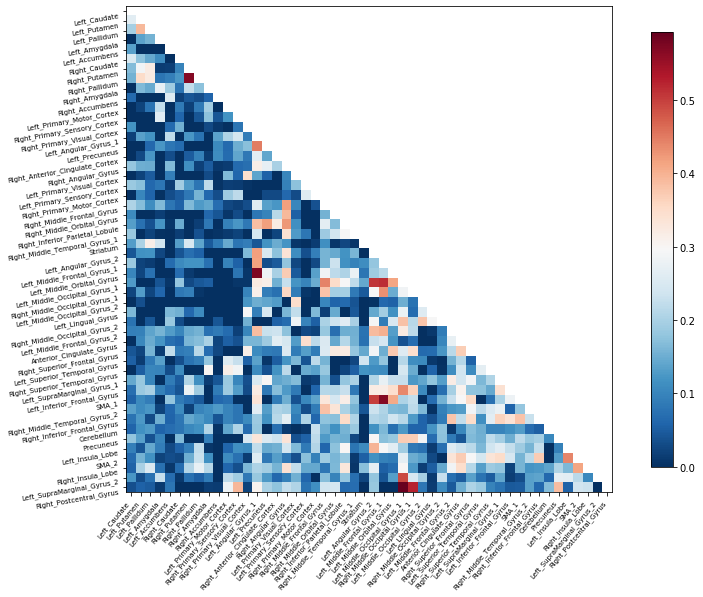

In [40]:
label_data = pd.read_csv('/data/MBDU/midla/notebooks/campcc/atlas_labels.csv', header=None).values.tolist()
labels = []
for x in label_data:
    labels.append(x[0])
plotting.plot_matrix(fixed_df,labels=labels,tri='lower',figure=(10,10))

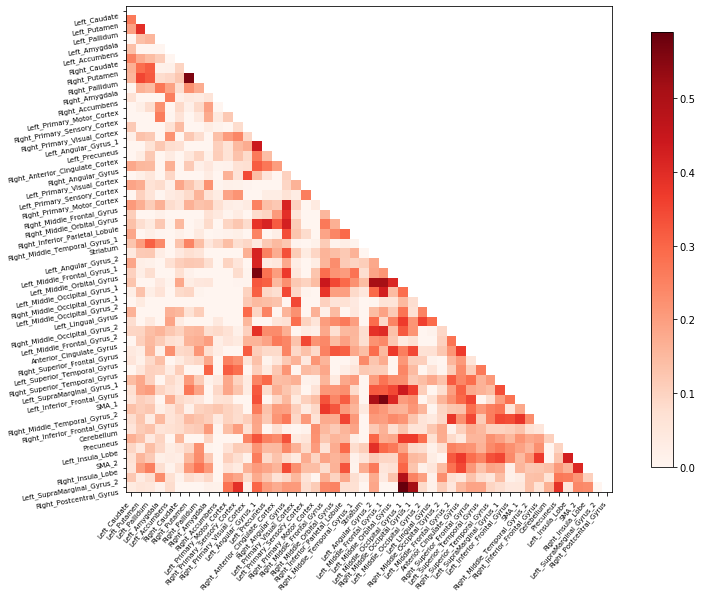

In [41]:
fig,ax = plt.subplots(1,figsize = (10,10))
plotting.plot_matrix(random_df, figure = fig,labels=labels,tri='lower',cmap = 'Reds')
fig.patch.set_facecolor('white')

In [ ]:
# Let's get pych's ICC 2,1 and 3,1 for all fs stats in orig
single_ses_subs = fs_dat.loc[fs_dat.session.astype(int) <= 4, :].groupby('subject').session_id.nunique().reset_index().query('session_id <= 2').subject
dat_ind = ~fs_dat.subject.isin(single_ses_subs) & (fs_dat.session.astype(int) <= 4)
measure_iccs=[]
for mc in measure_cols:
    psych_dat = fs_dat.loc[dat_ind, ['subject', 'session', mc]].set_index(['subject', 'session']).unstack()
    mc_res = psych.ICC(psych_dat, missing=False)
    mc_res = mc_res[0].loc[['Single_random_raters', 'Single_fixed_raters']]
    mc_res['measure'] = mc
    measure_iccs.append(mc_res)
measure_iccs = pd.concat(measure_iccs)